# Project Overview

This notebook provides a brief overview of the competition, the data, and the approach I used in my solution. I encourage you to explore the rest of the code in this repository which contains the actual implementation!

### About the Competition Data

The "TGS Salt Identification Challenge" was a Kaggle competition wherein the goal was to identify salt deposits in underground seismic images. The training data consisted of 4,000 seismic images along with corresponding masks identifying the salt deposits, and predictions were made on 18,000 images.

Here are some examples of the image/mask pairs:

Found existing saved dataset; loading it...


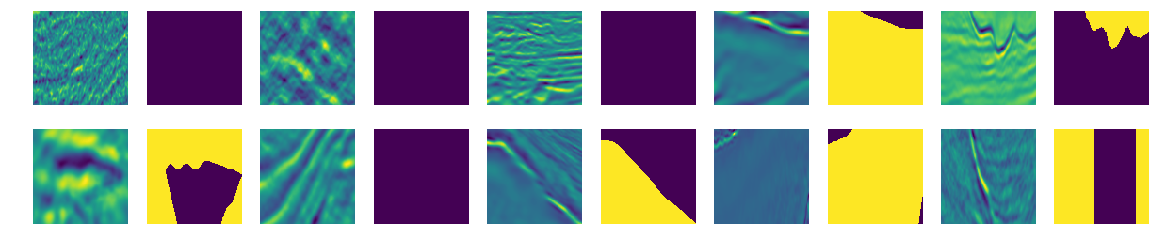

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from src.data import construct_data

np.random.seed(1)
train, test = construct_data()

def get_sample(n):
    random_ids = train.index[np.random.randint(0, train.shape[0], n)]
    images = train.loc[random_ids, 'image']
    masks = train.loc[random_ids, 'mask']
    return zip(images, masks)
    
#matplotlib inline
f = plt.figure(figsize=(20, 4))
for i, (image, mask) in enumerate(get_sample(10), start=1):
    f.add_subplot(2, 10, 2*i - 1)
    plt.imshow(image)
    plt.axis('off')
    f.add_subplot(2, 10, 2*i)
    plt.imshow(mask)
    plt.axis('off')
plt.show()

The training data is single-channel, so the neural network actually sees the images in grayscale. But since we're human beings, I'm adding some color to make these pictures of rocks more interesting. Here's what the masks look like overlayed on top of the seismic images:

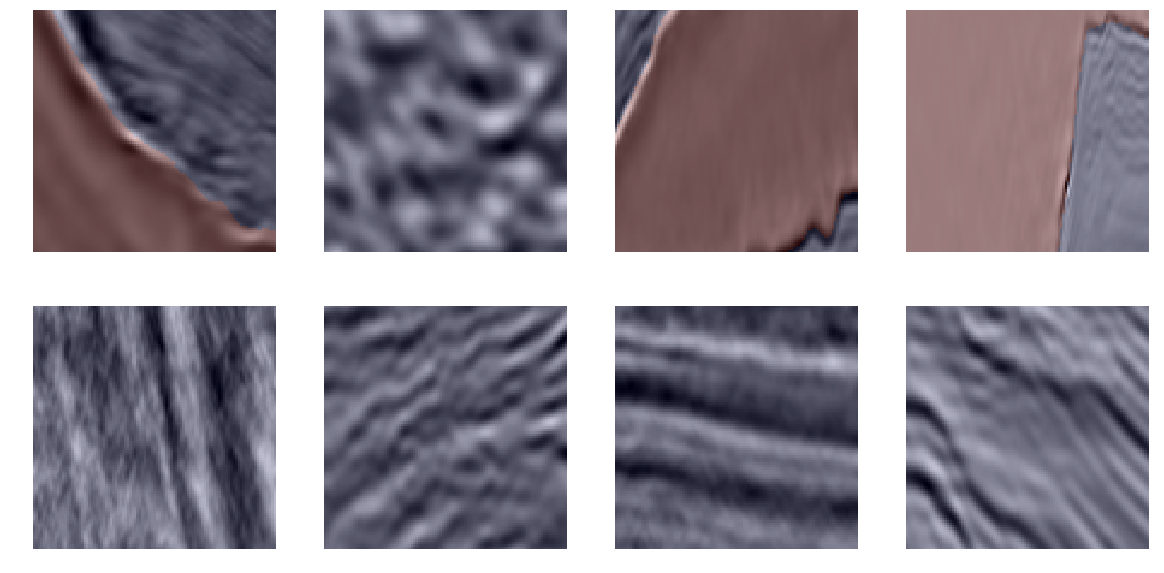

In [3]:
f = plt.figure(figsize=(20, 10))
for i, (image, mask) in enumerate(get_sample(8), start=1):
    f.add_subplot(2, 4, i)
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='seismic', alpha=0.25)
    plt.axis('off')
plt.show()

### About the Model

The model I use to make predictions is a deep convolutional neural network. Its has two distinctive features:

* The network has a "U-Net" structure, a very popular architecture which was originally designed for biomedial image segmentation. The basic premise is to send the images through successive convolutional rounds, downsizing at each round, and then send them through an equal number of upsizing rounds. This forms a "U" shape in the network.
* In addition to the connections between each convolution round in "U" shape, there are "skip connections" between each downsizing round and its corresponding upsizing round. This is known as a "residual" network architecture.

In the `papers/` directory of this repository, the research papers by Ronneberger et al. (2015) and Huang et al. (2018) provide more in-depth (and better) explanations of these features.

The effect of this structure is that — in theory — the network learns as much from the images at each resolution, and then resizes them to learn from the "residual" information they possess.

### Fitting the Model

We can fit the model for a few iterations to give an idea of how it works.

First, we'll pull out some of the data to use as a validation set. Stratifying by the amount of salt in the image helps to improve model accuracy.

In [4]:
from sklearn.model_selection import StratifiedKFold, train_test_split

train_indices, valid_indices = train_test_split(train.index.values,
                                                random_state=1,
                                                test_size=0.2,
                                                stratify=train['cov_class'])
training_set = train.loc[train_indices]
validation_set = train.loc[valid_indices]

Now, let's create the model and train it. It takes a while to train the model, so for this example let's only run it through 30 epochs. This won't be a enough to get great results, but it will at least demonstrate how the model works.

In [ ]:
from src.model import CustomResNet
from src.utilities import competition_metric

model = CustomResNet()
model.train(training_set['image'], training_set['mask'],
            validation_set['image'], validation_set['mask'],
            round1_epochs=20, round2_epochs=5, round3_epochs=5)

x_valid = model.process(validation_set['image'])
y_valid = model.process(validation_set['mask'])
y_pred = np.round(model.predict(x_valid) > model.optimal_cutoff)

Now, let's assess the accuracy:

In [14]:
from src.utilities import competition_metric

score = competition_metric(y_valid, y_pred)
print('The prediction accuracy is: {:.0%}'.format(score))

The prediction accuracy is: 45%


That's pretty low, but not too bad considering we used so few epochs. My final predictions for the competition ended up achieving 85.5% accuracy. Here's what the predictions look like:

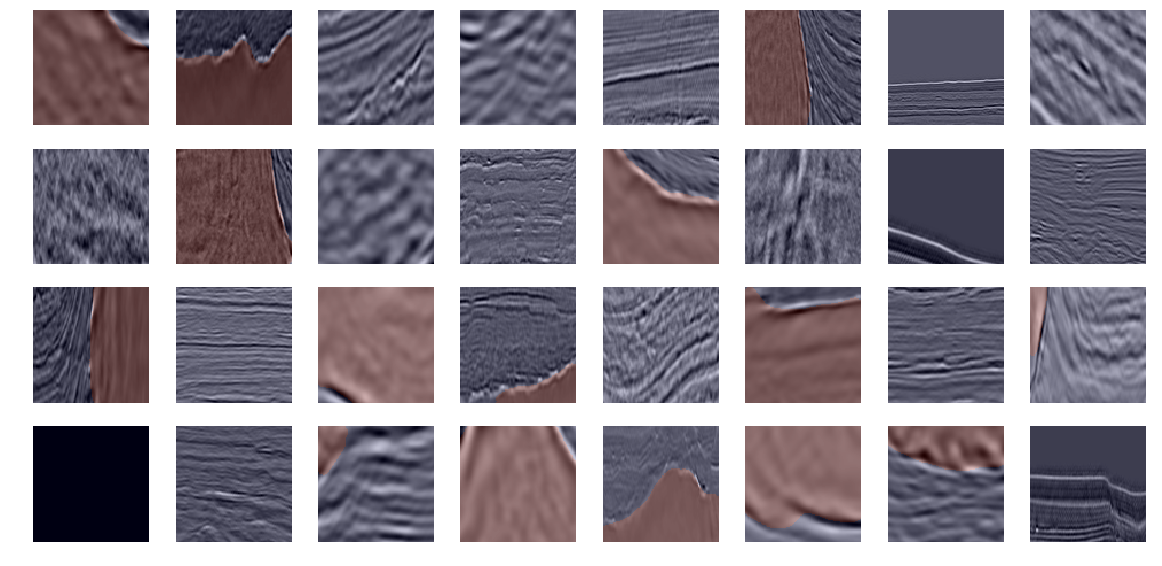

In [19]:
def get_sample(n):
    random_ids = np.random.randint(0, validation_set.shape[0], n)
    images = [x_valid[i] for i in random_ids]
    masks = [y_pred[i] for i in random_ids]
    return zip(images, masks)

f = plt.figure(figsize=(20, 20))
for i, (image, mask) in enumerate(get_sample(32), start=1):
    f.add_subplot(8, 8, i)
    plt.imshow(np.reshape(image, (101, 101)), cmap='gray')
    plt.imshow(np.reshape(mask, (101, 101)).astype(np.float64), cmap='seismic', alpha=0.25)
    plt.axis('off')
plt.show()

And that's it! Thanks for reading, and be sure to take a look at the source code in this repository as well.